# Addictive Model

## Libraries

In [74]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## Import Dataset

In [75]:
file_path = '../data/food_data_cleaned1.xlsx'
food_data = pd.ExcelFile(file_path)
data = food_data.parse('Sheet1')
data.head()

,Food Name,Energy (KJ/100g),Sugars (g/100g),Saturated Fat (g/100g),Salt (g/100g),Proteins (g/100g),Fiber (g/100g),Fruit/Veg (%),Categories,Countries,Barcode,Nutri-Score,Ecoscore
0,Sésame,1961.0,17.0,2.0,0.38,10.0,4.6,0,"Snacks,Snacks sucrés,Biscuits et gâteaux,Biscu...",en:france,3175680011480,b,57
1,Lindt Excellence 90% 100g,2590.0,7.0,30.0,0.03,10.0,14.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:algeria, en:belgium, en:czech-republic, en:...",3046920029759,d,29
2,Excellence 85% Cacao Chocolat Noir Puissant,2418.0,15.0,27.0,0.02,12.5,0.0,0,"Snacks,Sweet snacks,Cocoa and its products,Cho...","en:austria, en:belgium, en:france, en:germany,...",3046920022606,e,29
3,Cashews,2510.0,6.5,9.0,0.02,20.5,5.2,100,"Plant-based foods and beverages,Plant-based fo...","en:austria, en:belgium, en:croatia, en:france,...",20267605,b,30
4,Tuc Original,2021.0,7.1,9.0,1.70,8.3,2.4,0,"Imbiss,Salzige Snacks,Vorspeisen,en:Biscuits a...","en:austria, en:belgium, en:denmark, en:estonia...",5410041001204,e,62


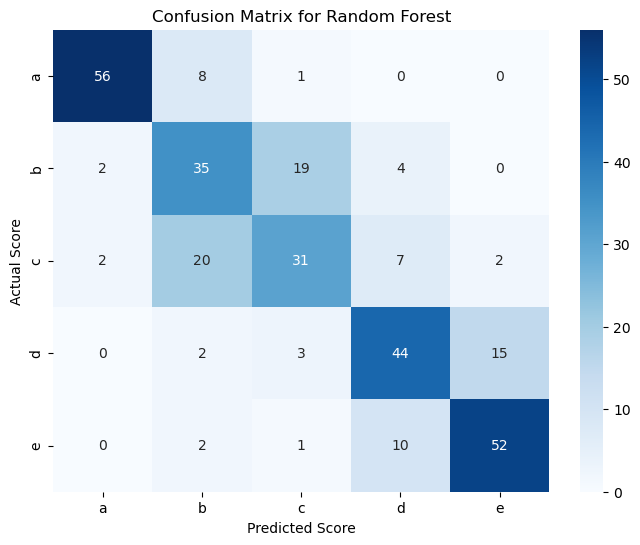

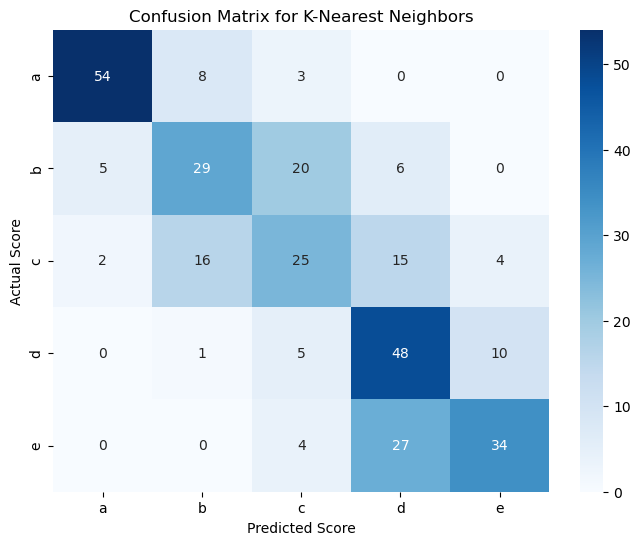

/home/yutao/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


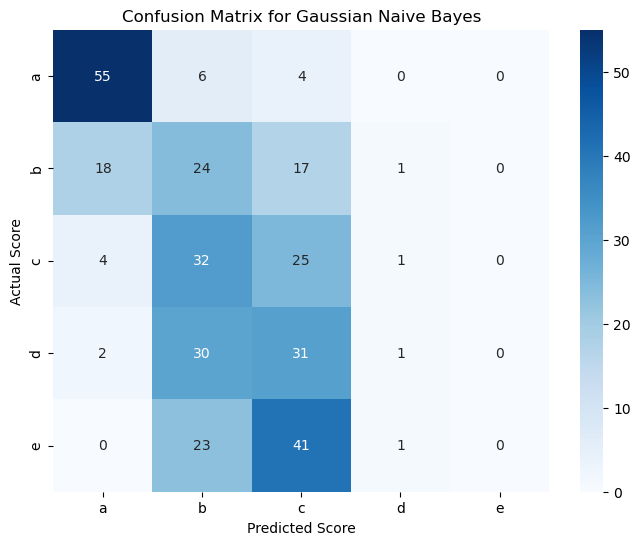

/home/yutao/.local/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [21:17:47] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


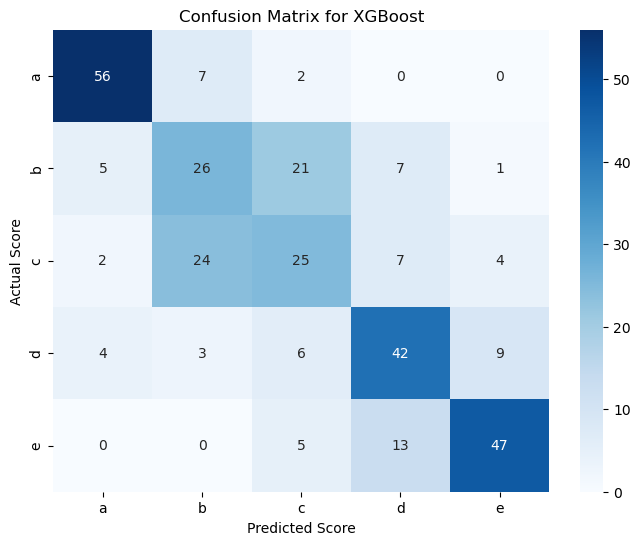

                  Model  Accuracy  Precision    Recall  F1-Score
0         Random Forest  0.689873   0.693873  0.689873  0.690735
1   K-Nearest Neighbors  0.601266   0.617082  0.601266  0.600652
2  Gaussian Naive Bayes  0.332278   0.275033  0.332278  0.269666
3               XGBoost  0.620253   0.619108  0.620253  0.619255


In [ ]:
def AnotherMethodNutriScoreWithVisualization(data, nutri_score_mapping, test_size=0.8, random_state=1):
    data['Nutri-Score'] = data['Nutri-Score'].map(nutri_score_mapping)
    data = data.dropna(subset=['Nutri-Score'])
    data['Nutri-Score'] -= 1

    features = ['Energy (KJ/100g)', 'Proteins (g/100g)', 'Salt (g/100g)', 
                'Fiber (g/100g)', 'Saturated Fat (g/100g)', 'Sugars (g/100g)', 
                'Fruit/Veg (%)', 'Ecoscore']
    X = data[features]
    y = data['Nutri-Score']
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
    X = poly.fit_transform(X)
    
    smote = SMOTE(random_state=random_state)
    X, y = smote.fit_resample(X, y)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    models = {
        "Random Forest": RandomForestClassifier(random_state=random_state, class_weight="balanced"),
        "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
        "Gaussian Naive Bayes": GaussianNB(),
        "XGBoost": XGBClassifier(random_state=random_state, use_label_encoder=False, eval_metric='mlogloss')
    }
    
    performance = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        y_pred += 1
        y_test_vis = y_test + 1  
        
        accuracy = accuracy_score(y_test_vis, y_pred)
        precision = precision_score(y_test_vis, y_pred, average='weighted')
        recall = recall_score(y_test_vis, y_pred, average='weighted')
        f1 = f1_score(y_test_vis, y_pred, average='weighted')
        
        performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })
        
        labels = ['a', 'b', 'c', 'd', 'e'] 
        plot_confusion_matrix(y_test_vis, y_pred, labels, title=f"Confusion Matrix for {name}")
    
    performance_df = pd.DataFrame(performance)
    print(performance_df)

def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=[i + 1 for i in range(len(labels))])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Score')
    plt.ylabel('Actual Score')
    plt.title(title)
    plt.show()

if __name__ == "__main__":
    nutri_score_mapping = {'a': 5, 'b': 4, 'c': 3, 'd': 2, 'e': 1}

    AnotherMethodNutriScoreWithVisualization(data, nutri_score_mapping)

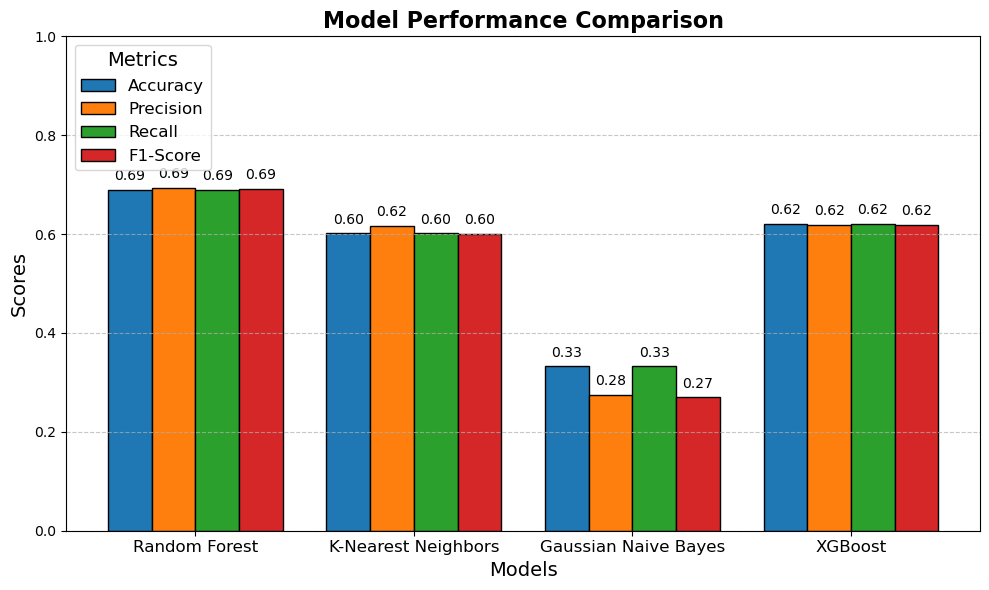

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Data for visualization
data = {
    "Model": ["Random Forest", "K-Nearest Neighbors", "Gaussian Naive Bayes", "XGBoost"],
    "Accuracy": [0.689873, 0.601266, 0.332278, 0.620253],
    "Precision": [0.693873, 0.617082, 0.275033, 0.619108],
    "Recall": [0.689873, 0.601266, 0.332278, 0.620253],
    "F1-Score": [0.690735, 0.600652, 0.269666, 0.619255]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df["Model"]))
width = 0.2

ax.bar(x - 1.5 * width, df["Accuracy"], width, label="Accuracy", edgecolor="black", linewidth=1)
ax.bar(x - 0.5 * width, df["Precision"], width, label="Precision", edgecolor="black", linewidth=1)
ax.bar(x + 0.5 * width, df["Recall"], width, label="Recall", edgecolor="black", linewidth=1)
ax.bar(x + 1.5 * width, df["F1-Score"], width, label="F1-Score", edgecolor="black", linewidth=1)

ax.set_xlabel("Models", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_title("Model Performance Comparison", fontsize=16, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels(df["Model"], fontsize=12)
ax.set_ylim(0, 1)  
ax.legend(title="Metrics", loc="upper left", fontsize=12, title_fontsize=14)

ax.grid(axis="y", linestyle="--", alpha=0.7)

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    for j, value in enumerate(df[metric]):
        ax.text(
            x[j] + (i - 1.5) * width,
            value + 0.02,
            f"{value:.2f}",
            ha="center",
            fontsize=10
        )

plt.tight_layout()
plt.show()

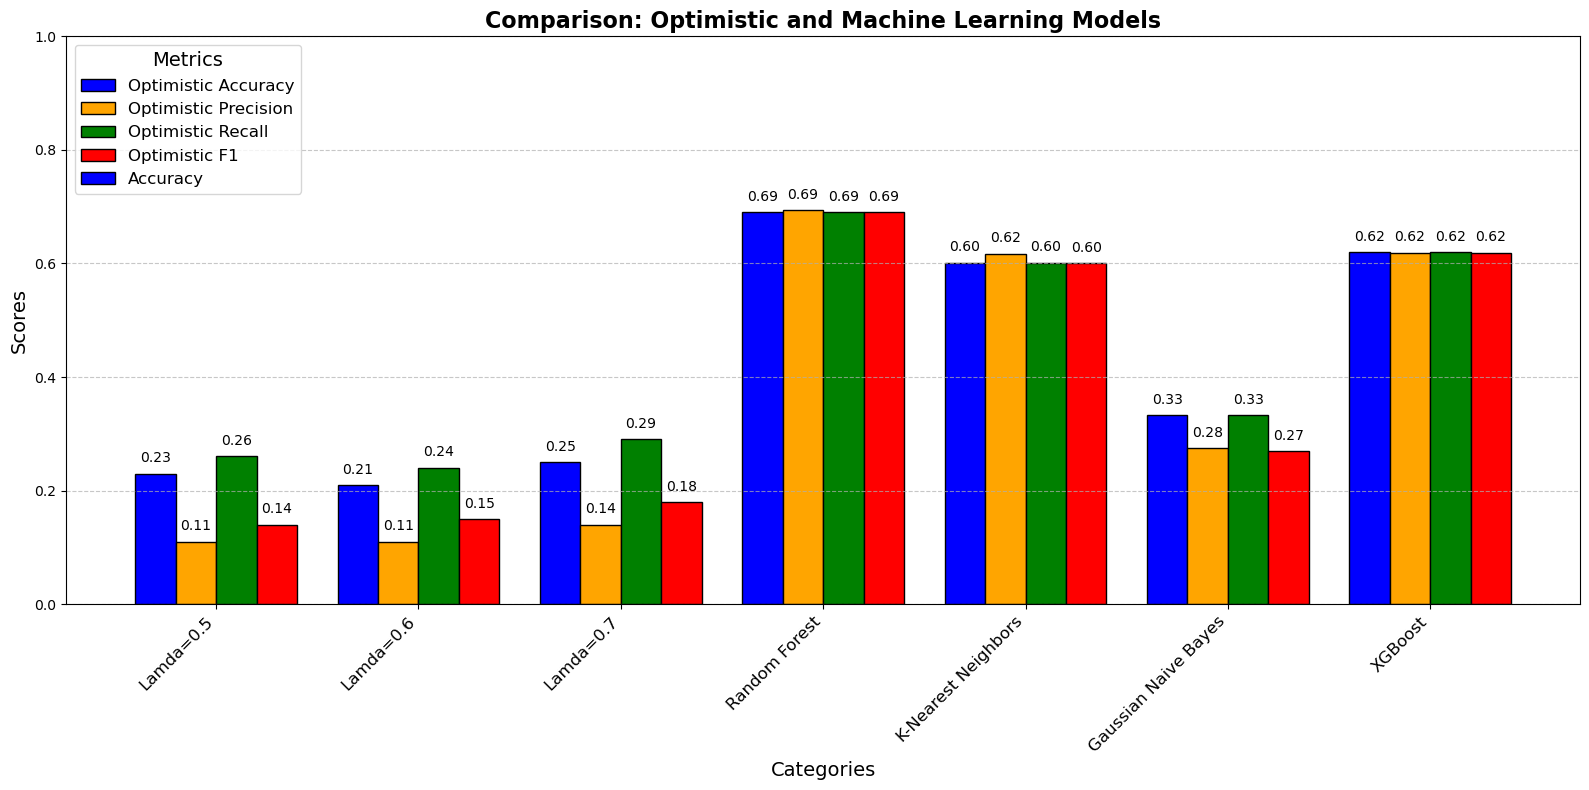

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

lambda_data = {
    "Lambda": ["Lamda=0.5", "Lamda=0.6", "Lamda=0.7"],
    "Optimistic_Accuracy": [0.23, 0.21, 0.25],
    "Optimistic_Precision": [0.11, 0.11, 0.14],
    "Optimistic_Recall": [0.26, 0.24, 0.29],
    "Optimistic_F1": [0.14, 0.15, 0.18]
}

ml_data = {
    "Model": ["Random Forest", "K-Nearest Neighbors", "Gaussian Naive Bayes", "XGBoost"],
    "Accuracy": [0.689873, 0.601266, 0.332278, 0.620253],
    "Precision": [0.693873, 0.617082, 0.275033, 0.619108],
    "Recall": [0.689873, 0.601266, 0.332278, 0.620253],
    "F1-Score": [0.690735, 0.600652, 0.269666, 0.619255]
}

lambda_df = pd.DataFrame(lambda_data)
ml_df = pd.DataFrame(ml_data)

fig, ax = plt.subplots(figsize=(16, 8))

x_lambda = np.arange(len(lambda_df["Lambda"]))
x_ml = np.arange(len(ml_df["Model"]))
width = 0.2

# Define colors
colors = {
    "Accuracy": "blue",
    "Precision": "orange",
    "Recall": "green",
    "F1": "red"
}

metrics = ["Accuracy", "Precision", "Recall", "F1"]
for i, metric in enumerate(metrics):
    opt_values = lambda_df[f"Optimistic_{metric}"]
    ax.bar(x_lambda + (i - 1.5) * width, opt_values, width, label=f"Optimistic {metric}", color=colors[metric], edgecolor="black", linewidth=1)

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    ax.bar(x_ml + len(x_lambda) + (i - 1.5) * width, ml_df[metric], width, label=metric if i == 0 else "", color=colors[metric.split('-')[0]], edgecolor="black", linewidth=1)

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_title("Comparison: Optimistic and Machine Learning Models", fontsize=16, fontweight="bold")
ax.set_xticks(np.concatenate([x_lambda, x_ml + len(x_lambda)]))
ax.set_xticklabels(list(lambda_df["Lambda"]) + list(ml_df["Model"]), fontsize=12, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.legend(title="Metrics", loc="upper left", fontsize=12, title_fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)

for i, metric in enumerate(metrics):
    opt_values = lambda_df[f"Optimistic_{metric}"]
    for j, o_value in enumerate(opt_values):
        ax.text(x_lambda[j] + (i - 1.5) * width, o_value + 0.02, f"{o_value:.2f}", ha="center", fontsize=10)

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    for j, value in enumerate(ml_df[metric]):
        ax.text(x_ml[j] + len(x_lambda) + (i - 1.5) * width, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()

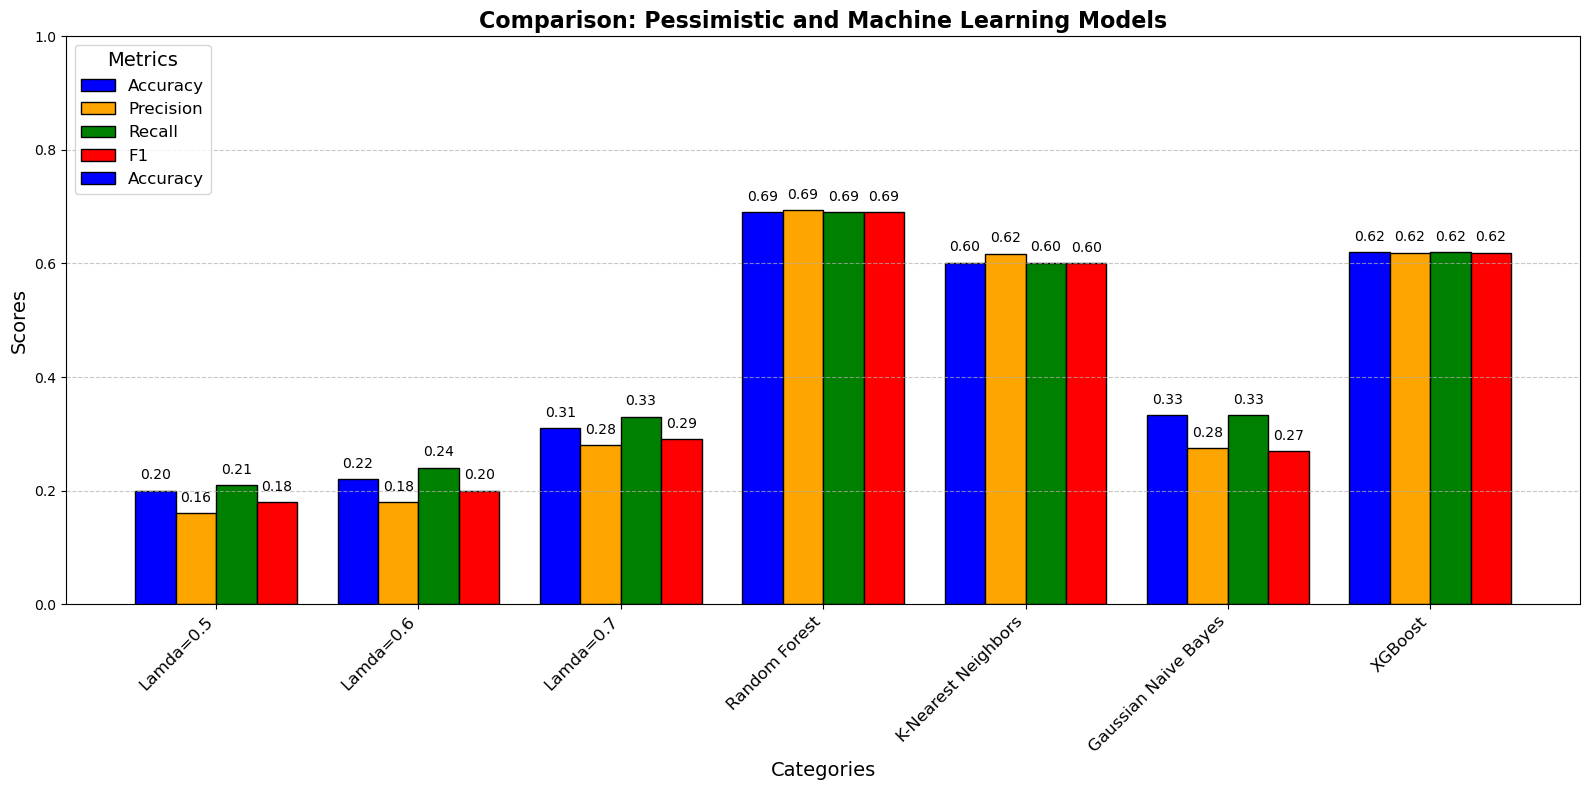

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

lambda_data = {
    "Lambda": ["Lamda=0.5", "Lamda=0.6", "Lamda=0.7"],
    "Pessimistic_Accuracy": [0.20, 0.22, 0.31],
    "Pessimistic_Precision": [0.16, 0.18, 0.28],
    "Pessimistic_Recall": [0.21, 0.24, 0.33],
    "Pessimistic_F1": [0.18, 0.20, 0.29]
}

ml_data = {
    "Model": ["Random Forest", "K-Nearest Neighbors", "Gaussian Naive Bayes", "XGBoost"],
    "Accuracy": [0.689873, 0.601266, 0.332278, 0.620253],
    "Precision": [0.693873, 0.617082, 0.275033, 0.619108],
    "Recall": [0.689873, 0.601266, 0.332278, 0.620253],
    "F1-Score": [0.690735, 0.600652, 0.269666, 0.619255]
}

lambda_df = pd.DataFrame(lambda_data)
ml_df = pd.DataFrame(ml_data)

fig, ax = plt.subplots(figsize=(16, 8))

x_lambda = np.arange(len(lambda_df["Lambda"]))
x_ml = np.arange(len(ml_df["Model"]))
width = 0.2

colors = {
    "Accuracy": "blue",
    "Precision": "orange",
    "Recall": "green",
    "F1": "red"
}

metrics = ["Accuracy", "Precision", "Recall", "F1"]
for i, metric in enumerate(metrics):
    pess_values = lambda_df[f"Pessimistic_{metric}"]
    ax.bar(x_lambda + (i - 1.5) * width, pess_values, width, label=metric, color=colors[metric], edgecolor="black", linewidth=1)

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    ax.bar(x_ml + len(x_lambda) + (i - 1.5) * width, ml_df[metric], width, label=metric if i == 0 else "", color=colors[metric.split('-')[0]], edgecolor="black", linewidth=1)

ax.set_xlabel("Categories", fontsize=14)
ax.set_ylabel("Scores", fontsize=14)
ax.set_title("Comparison: Pessimistic and Machine Learning Models", fontsize=16, fontweight="bold")
ax.set_xticks(np.concatenate([x_lambda, x_ml + len(x_lambda)]))
ax.set_xticklabels(list(lambda_df["Lambda"]) + list(ml_df["Model"]), fontsize=12, rotation=45, ha="right")
ax.set_ylim(0, 1)
ax.legend(title="Metrics", loc="upper left", fontsize=12, title_fontsize=14)
ax.grid(axis="y", linestyle="--", alpha=0.7)

for i, metric in enumerate(metrics):
    pess_values = lambda_df[f"Pessimistic_{metric}"]
    for j, p_value in enumerate(pess_values):
        ax.text(x_lambda[j] + (i - 1.5) * width, p_value + 0.02, f"{p_value:.2f}", ha="center", fontsize=10)

for i, metric in enumerate(["Accuracy", "Precision", "Recall", "F1-Score"]):
    for j, value in enumerate(ml_df[metric]):
        ax.text(x_ml[j] + len(x_lambda) + (i - 1.5) * width, value + 0.02, f"{value:.2f}", ha="center", fontsize=10)

plt.tight_layout()
plt.show()
